In [1]:
!pip install ultralytics
import os, shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

In [2]:
# Define paths to the C2A dataset
base_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3"
train_img_dir = os.path.join(base_path, "train", "images")
train_lbl_dir = os.path.join(base_path, "train", "labels")
val_img_dir   = os.path.join(base_path, "val", "images")
val_lbl_dir   = os.path.join(base_path, "val", "labels")

# Create a working directory for the filtered flood-only dataset
work_dir = "/kaggle/working/flood_yolo"
for subdir in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(work_dir, subdir), exist_ok=True)

In [3]:
# Filter flood images in training set
flood_train_imgs = [f for f in os.listdir(train_img_dir) if f.startswith("flood_image")]
# Filter flood images in validation set
flood_val_imgs = [f for f in os.listdir(val_img_dir) if f.startswith("flood_image")]

print(f"Found {len(flood_train_imgs)} flood training images and {len(flood_val_imgs)} flood validation images.")

# Copy filtered images and labels into the working directory
for img_file in flood_train_imgs:
    # Define source paths
    src_img = os.path.join(train_img_dir, img_file)
    src_lbl = os.path.join(train_lbl_dir, img_file.replace(".png", ".txt"))
    # Define destination paths
    dst_img = os.path.join(work_dir, "images/train", img_file)
    dst_lbl = os.path.join(work_dir, "labels/train", img_file.replace(".png", ".txt"))
    # Copy the files
    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)

for img_file in flood_val_imgs:
    src_img = os.path.join(val_img_dir, img_file)
    src_lbl = os.path.join(val_lbl_dir, img_file.replace(".png", ".txt"))
    dst_img = os.path.join(work_dir, "images/val", img_file)
    dst_lbl = os.path.join(work_dir, "labels/val", img_file.replace(".png", ".txt"))
    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)

Found 1529 flood training images and 542 flood validation images.


Total bounding boxes (train+val): 70732
Min area: 0.1, Max area: 20944.6, Mean area: 1085.9


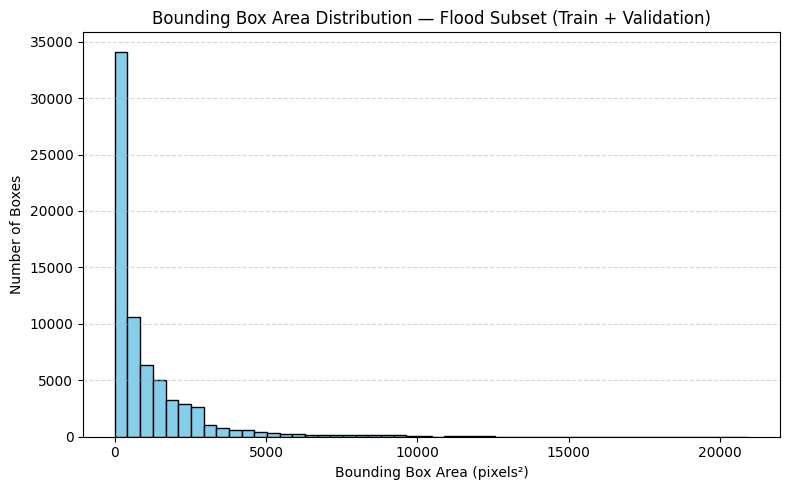

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Image size (YOLO normalized to 960x960)
IMG_SIZE = 960

# Paths to labels
train_lbl_dir = "/kaggle/working/flood_yolo/labels/train"
val_lbl_dir   = "/kaggle/working/flood_yolo/labels/val"

# Function to get bounding box areas from a label directory
def collect_bbox_areas(label_dir, img_size=IMG_SIZE):
    areas = []
    for lbl_file in os.listdir(label_dir):
        if not lbl_file.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, lbl_file), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                try:
                    # YOLO normalized width and height
                    w_norm = float(parts[3])
                    h_norm = float(parts[4])
                    # Convert to pixels
                    w_pix = w_norm * img_size
                    h_pix = h_norm * img_size
                    area = w_pix * h_pix
                    areas.append(area)
                except ValueError:
                    continue
    return areas

# Collect areas from both train and validation
train_areas = collect_bbox_areas(train_lbl_dir)
val_areas   = collect_bbox_areas(val_lbl_dir)

all_areas = train_areas + val_areas

print(f"Total bounding boxes (train+val): {len(all_areas)}")
print(f"Min area: {min(all_areas):.1f}, Max area: {max(all_areas):.1f}, Mean area: {sum(all_areas)/len(all_areas):.1f}")

# ---- Plot histogram ----
plt.figure(figsize=(8,5))
plt.hist(all_areas, bins=50, color='skyblue', edgecolor='black')
plt.title("Bounding Box Area Distribution — Flood Subset (Train + Validation)")
plt.xlabel("Bounding Box Area (pixels²)")
plt.ylabel("Number of Boxes")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# ---- Save figure in Kaggle working directory ----
plt.savefig("/kaggle/working/bbox_area_histogram.png", dpi=300)
plt.show()